Notebook presenting basic rejection sampling and Gillespie algorithms for simulating an SIR process in a mean field population.

# Import libraries

In [26]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt

from numpy.random import Generator, PCG64

In [27]:
#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state 
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x000001F918AE8F60>


# Functions 

In [28]:
##################################################################################################

def rejection_sampling_SIR_MF(beta_k, mu, dt, T, S, I, R):
    '''
    Simulates the mean field SIR process using rejection sampling.
    
    --- Input: ---
    beta_k: mean-field infection rate for an S-I pair of individuals, beta_k = beta * k / N
    mu    : recovery rate of an infectious individual
    dt    : time step of simulations
    T     : temporal length of simulation
    S     : initial number of susceptible individuals
    I     : initial number of infectious individuals
    R     : initial number of recovered individuals
    
    --- Outputs: ---
    X_t : numpy array of numbers of susceptible, infectious, and recovered individuals at discrete points in time, 
          X_t[n] = [n * dt, S, I, R]
    '''

    #--- Vector to save temporal evolution over time: ---
    X_t = []
    X_t.append([0., S, I, R])

    for i in range(int(T / dt)):
        #--- Infection and recovery probabilites in single time step: ---
        p_inf = S * I * beta_k * dt
        p_rec = I * mu * dt

        # Check if transition probabilities sum to zero (no more reactions can happen):
        if np.isclose(p_inf + p_rec, 0.):
            # Save final state and break loop:
            X_t.append([T, S, I, R])
            break

        #--- Rejection sampling step: ---
        # Draw two uniform random variates (for each possible reaction):
        u1, u2 = rg.random(2)
        
        # Check if an S->I reaction takes place:
        if u1 < p_inf:
            S -= 1
            I += 1
        # Check if an I->R reaction takes place:
        if u2 < p_rec:
            I -= 1
            R += 1

        #--- Save current state to X_t: ---
        X_t.append([(i + 1) * dt, S, I, R])
        
    return(np.array(X_t).transpose())

##################################################################################################
##################################################################################################

def direct_method_SIR_MF(beta_k, mu, T, S, I, R):
    '''
    Simulates the mean field SIR process using Gillespie's direct method.
    
    --- Input: ---
    beta_k: mean-field infection rate for an S-I pair of individuals, beta_k = beta * k / N
    mu    : recovery rate of an infectious individual
    T     : temporal length of simulation
    S     : initial number of susceptible individuals
    I     : initial number of infectious individuals
    R     : initial number of recovered individuals
    
    --- Outputs: ---
    X_t : numpy array of numbers of susceptible, infectious, and recovered individuals at each point in time, 
          X_t[n] = [t_n, S, I, R]
    '''
    
    # Initialize time to zero:
    t = 0
    
    #--- Vector to save temporal evolution of system state over time: ---
    X_t = [] 
    X_t.append([t, S, I, R])

    while t < T:
        #--- Infection and recovery probabilites in single time step: ---
        a_inf = S * I * beta_k 
        a_rec = I * mu 
        # Cumulative infection rate:
        a_sum = a_inf + a_rec
        
        # Check for a_sum == 0 (no more reactions can happen):
        if np.isclose(a_sum, 0.):
            # Save final state and break loop:
            X_t.append([T, S, I, R])
            break

        #--- Direct event sampling step: ---
        # Draw two uniform random variates (for waiting time and reaction selection):
        u1, u2 = rg.random(2)
        
        # Draw waiting time and increment real time:
        tau = - np.log(1. - u1) / a_sum # rg.random generates u ~ U([0,1)), so use 1 - u to avoid log(0)
        t += tau

        #--- Select reaction and update state ---:
        # S->I reaction:
        if u2 * a_sum < a_inf:
            S -= 1
            I += 1
        
        # I->R reaction:
        else:
            I -= 1
            R += 1
                
        #--- Save current state to X_t: ---
        X_t.append([t, S, I, R])
        
    return(np.array(X_t).transpose())

##################################################################################################
##################################################################################################

def first_reaction_method_SIR_MF(beta_k, mu, T, S, I, R):
    '''
    Simulates the mean field SIR process using Gillespie's first reaction method.
    
    --- Input: ---
    beta_k: mean-field infection rate for an S-I pair of individuals, beta_k = beta * k / N
    mu    : recovery rate of an infectious individual
    T     : temporal length of simulation
    S     : initial number of susceptible individuals
    I     : initial number of infectious individuals
    R     : initial number of recovered individuals
    
    --- Outputs: ---
    X_t : numpy array of numbers of susceptible, infectious, and recovered individuals at each point in time, 
          X_t[n] = [t_n, S, I, R]
    '''

    # Initialize time to zero:
    t = 0
    
    #--- Vector to save temporal evolution over time: ---
    X_t = [] 
    X_t.append([t, S, I, R])

    while t < T:
        #--- Calculate infection and recovery rates: ---
        propensities = np.array([S * I * beta_k, I * mu])
        
        # Select channels with non-zero propensities to avoid drawing unnecessesary variates and dividing by zero: 
        nonzero_propensities = propensities[propensities > 0.]
        nonzero_channels = np.where(propensities > 0.)[0]
        n_channels = len(nonzero_propensities)
        
        # Check if no non-zero propensities remain (no more reactions can happen):
        if  n_channels == 0:
            # Save final state and break loop:
            X_t.append([T, S, I, R])
            break

        #--- First reaction event sampling step: ---
        # Draw a uniform random variate for each waiting time:
        us = rg.random(n_channels)
        
        # Draw waiting times:
        taus = - np.log(1. - us) / nonzero_propensities # rg.random generates u ~ U([0,1)), so use 1 - u to avoid log(0)
      
        # Select reaction with minimal tau:
        tau_min    = np.min(taus)
        i_selected = nonzero_channels[np.argmin(taus)]
        
        # Update time:
        t += tau_min

        #--- Select reaction and update state ---:
        # S->I reaction:
        if i_selected == 0:
            S -= 1
            I += 1
            
        # I->R reaction:
        else:
            I -= 1
            R += 1
                
        #--- Save current state to X_t: ---
        X_t.append([t, S, I, R])
        
    return(np.array(X_t).transpose())

##################################################################################################

# Simulations

## Rejection sampling grouped by reaction type
Two reaction channels: 1) for an infection between of any S individual and 2) for a recovery of any infectious individual.

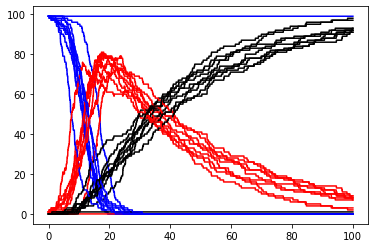

In [29]:
#--- Simulation parameters: ---
beta   = 0.1   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration
dt     = 0.001  # Time step length

# Effective mean field infection rate:
beta_k = beta * float(k) / float(N) 

# Number of independent runs of the simulation:
number_of_simulations = 10 

#--- Initial state: ---
I0 = 1            # Number of infected (seed) nodes at start of simulation
R0 = 0            # Number of recovered nodes at start of simulation
S0 = N - I0 - R0  # Set number of susceptible nodes from N = S + I + R

X_array = []
for q in range(number_of_simulations):    
    X_array.append(rejection_sampling_SIR_MF(beta_k, mu, dt, T, S0, I0, R0))

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

## Direct method
One reaction channel for each S individual (infection) and each I individual (recovery).

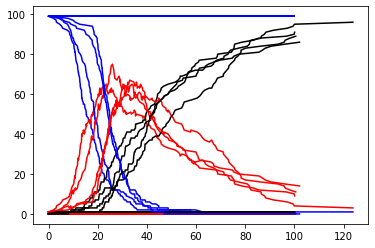

In [30]:
#--- Simulation parameters: ---
beta   = 0.05   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

# Effective mean field infection rate:
beta_k = beta * float(k) / float(N) 

# Number of independent runs of the simulation:
number_of_simulations = 10 

#--- Initial state: ---
I0 = 1            # Number of infected (seed) nodes at start of simulation
R0 = 0            # Number of recovered nodes at start of simulation
S0 = N - I0 - R0  # Set number of susceptible nodes from N = S + I + R

X_array = []
for q in range(number_of_simulations):    
    X_array.append(direct_method_SIR_MF(beta_k, mu, T, S0, I0, R0))

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

## First reaction method

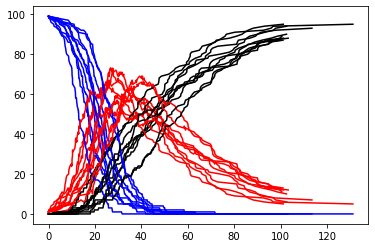

In [31]:

#--- Simulation parameters: ---
beta   = 0.05   # Infection rate
mu     = 0.03  # Recovery rate
k      = 5     # Mean degree
N      = 100   # Number of nodes
T      = 100   # Simulation duration

# Effective mean field infection rate:
beta_k = beta * float(k) / float(N) 

# Number of independent runs of the simulation:
number_of_simulations = 10 

#--- Initial state: ---
I0 = 1            # Number of infected (seed) nodes at start of simulation
R0 = 0            # Number of recovered nodes at start of simulation
S0 = N - I0 - R0  # Set number of susceptible nodes from N = S + I + R

X_array = []
for q in range(number_of_simulations):    
    X_array.append(first_reaction_method_SIR_MF(beta_k, mu, T, S0, I0, R0))

#=============================================================================================
# Plot:
#=============================================================================================
colors = ['b','r','k']

fig = plt.figure()
ax  = plt.subplot()

for X_t in X_array:
    [ax.plot(X_t[0],X_,c=c_) for X_,c_ in zip(X_t[1:],colors)]

# Speed comparison 

## Rejection sampling 

In [32]:
%timeit rejection_sampling_SIR_MF(beta_k, mu, dt, T, S0, I0, R0)

The slowest run took 79.95 times longer than the fastest. This could mean that an intermediate result is being cached.
2.5 s ± 1.01 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Direct method 

In [33]:
%timeit direct_method_SIR_MF(beta_k, mu, T, S0, I0, R0)

5.32 ms ± 204 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## First reaction method 

In [34]:
%timeit first_reaction_method_SIR_MF(beta_k, mu, T, S0, I0, R0)

2.96 ms ± 78 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
